In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import random
import time
import tracemalloc

In [2]:
data_size = 30

# GD

In [3]:
def num_diff(f, point, diff_coordinate, delta=1e-7):
    plus_delta = point.copy()
    plus_delta[diff_coordinate] += delta
    minus_delta = point.copy()
    minus_delta[diff_coordinate] -= delta
    return (f(plus_delta) - f(minus_delta)) / (2 * delta)

def grad(f, point):
    return np.array([num_diff(f, point, i) for i in range(len(point))])

def gd(f, lr, start, epoch=20):
    point = start
    points = list()
    current_result = list()
    points.append(point)
    for i in range(1, epoch):
        current_result.append(f(point))
        point = point - lr * np.array(grad(f, point))
        points.append(point)

        if np.linalg.norm(grad(f, point)) < 1e-7:
            break
    return [np.array(points), np.array(current_result)]

# Adam

In [4]:
def sgd_adam(f, start, lr, epoch=1000, gamma_1=0.9, gamma_2=0.999, eps=1e-8):
    point = start.copy()
    v_prev = np.zeros(len(point))
    s_prev = np.zeros(len(point))
    points = list()
    current_result = list()
    points.append(start)
    i = 1
    while i < epoch:
        g = np.array(grad(f, point))
        current_result.append(f(point))
        v_current = gamma_1 * v_prev + (1 - gamma_1) * g
        s_current = gamma_2 * s_prev + (1 - gamma_2) * np.power(g, 2)
        v_normalize = v_current / (1 - np.power(gamma_1, i))
        s_normalize = s_current / (1 - np.power(gamma_2, i))
        point = point - lr * v_normalize / np.power(s_normalize + eps, 0.5)
        v_prev = v_current
        s_prev = s_current
        points.append(point)
        i += 1
        if np.linalg.norm(grad(minimizing_func, point)) < 1e-7:
            break
    return np.array(points), np.array(current_result)

# Метод Gauss-Newton
Пусть дана функция $f(x) = \frac{1}{2} \sum_{i=1}^{m} r_i(x)^2$, где $r_i$ - произвольная функция.

Градиент функции f: $\displaystyle \frac{\partial f}{\partial x_j} = \sum_{i=1}^{m} r_i(x) \cdot \frac{\partial r_i(x)}{\partial x_j}$ <br>

Якобиан:  $\mathfrak{J}(x) = [\frac{\partial r_i(x)}{\partial x_j}] =
\begin{bmatrix}
\nabla r_1(x)^T\\
...\\
\nabla r_n(x)^T\\
\end{bmatrix}
$ <br>

$\nabla f(x) = \mathfrak{J}(x)^T \cdot r(x)$ <br>

Гессиан: $H = [\frac{\partial^2 f}{\partial x_j \partial x_k}] =\sum_{i=1}^{m}(\frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} + r_i \frac{\partial^2 r_i}{\partial x_j \partial x_k}) = \sum_{i=1}^{m}(\nabla r_i(x) \cdot \nabla r_i(x)^T) + \sum_{i=1}^{m}(\nabla r_i(x) \cdot \nabla^2 r_i(x)) = \mathfrak{J}(x)^T \cdot \mathfrak{J}(x) + \sum_{i=1}^{m}(\nabla r_i(x) \cdot \nabla^2 r_i(x))$ <br>

В методе Гаусса-Ньютона используется апроксимация гессиана (отбрасывается второй член, так как предпологается, что он намного меньше первого): $ \nabla^2 f(x) = H \approx \mathfrak{J}(x)^T \cdot \mathfrak{J}(x)$ <br>

В методе Ньютона направление шага алгоритма вычисляется по формуле: $\nabla^2 f(x_k) \cdot p = -\nabla f(x_k) $<br>

Тогда для Гаусса-Ньютона эта формула будет выглядеть так:

$\mathfrak{J}_k^T \cdot \mathfrak{J}_k \cdot p_k = -\mathfrak{J}_k^T \cdot r_k$ <br>

$p_k = -(\mathfrak{J}_k^T \cdot \mathfrak{J}_k)^{-1} \cdot \mathfrak{J}_k^T \cdot r_k $ <bk>

Следовательно: $ x_{k+1} = x_k - \alpha \cdot (\mathfrak{J}^T \cdot \mathfrak{J})^{-1} \cdot \mathfrak{J}^T \cdot r $ <bk>


In [5]:
#n = 4 # количество точек в r ?
m = 300 # из сумм в ячейке выше

In [6]:
def nolinear_sum(a, indexes=range(300)):
    sum = 0
    for i in indexes:
        sum += (func(xs[i], *a) - ys[i]) ** 2
    return sum

In [7]:
def num_diff2(f, point, i, indexes, delta = 1e-7):
    plus_delta = point.copy()
    plus_delta[i] += delta
    minus_delta = point.copy()
    minus_delta[i] -= delta
    return (f(plus_delta, indexes) - f(minus_delta, indexes)) / (2 * delta)

def grad2(f, point, i, indexes):
    return num_diff2(f, point, i, indexes)

In [8]:
def orienting(point):
    A = list()
    for i in range(n):
        row = list()
        for j in range(300):
            row.append(grad2(nolinear_sum, point, i, [j]))
        A.append(row)
    J = np.array(A).T
    r = list()
    for i in range(300):
        r.append(nolinear_sum(point, [i]))
    result_p = -np.linalg.inv(J.T @ J) @ J.T @ np.array(r).T
    return result_p

In [9]:
def newton(f, start, epoch=1000):
    def gradient_f(point):
        return grad(f, point)

    point = start
    points = list()
    current_result = list()
    points.append(start)
    for i in range(1, epoch):
        current_result.append(f(point))
        p = orienting(point)
        lr = opt.line_search(f, gradient_f, point, p)[0]
        point = point + lr * np.array(p)
        points.append(point)
        if np.linalg.norm(grad(f, point)) < 1e-7:
            break

    return np.array(points), current_result

# DogLeg
Метод Гаусса-Ньютона, как и метод Ньютона обладает таким свойством: хорошо сходится вблизи минимума, однако на отдалении от него функция может плохо апроксимироваться квадратичной, из-за чего появляются проблемы со сходимостью. В то же время градиентный спуск наоборот, хорошо сходится в отдалении от минимума, но плохо сходится в окрестности. Из этого собственно и произростает идея объединить эти 2 метода так, чтобы они показывали свои лучшие стороны. Идея метода DogLeg состоит в том, чтобы приближать нашу функцию квадратичной моделью в некоторой области Δ, искать минимум в этой области с помощью точного метода Ньютона, если же алгоритм скакнёт за пределы Δ, то с помощью градиентного спуска найти оптимальную точку на границе и переместится в неё, после чего создать новую область вокруг этой точки. <br>

Квадратичная модель выглядит следующим образом: $m_k(p) = f(x_k) + g^T p + \frac{1}{2} \cdot p^T B p, ||p|| ≤ Δ $ <br>

$\displaystyle p^U = - \frac{g^T g}{g^T B g} g$ - минимум вдоль направления градиента <br>

$p^B = \displaystyle - B^{-1} g$ - минимум квадратичной модели <br>

Если $p^B$ внутри доверительного региона, то шагаем в эту точку, иначе, если  $p^U$ вне области, то шагаем в пересечение сферы и прямой по направлению к $p^U$. В оставшемся случае шагаем в точку, которая находится на пересечении границы области и отрезка $p^U$ $p^B$. <br>

Область меняется по следующему принципу, введём коэффициент $ρ$:
$\displaystyle \rho_k = \frac{f(x_k) - f(x_k + p_k)}{m_k(0) - m_k(p_k)}$ <br>
, который будет оценивать оответсвие нашей модели заданной функции.
1. $ρ_k < \frac {1}{4}$, это означает, что модель плохо соотвествует функции и область нужно уменьшить: $Δ_{k+1} = \frac {1}{4} \cdot Δ_k$. <br>
2. $ρ_k > \frac {3}{4}$ и $||p_k|| = Δ_k$, тогда это значит, что мождель хорошо описывает функцию и область можн расширить:  $Δ_{k+1} = min(2 \cdot Δ_k, Δ_{max})$.
3. В оставшемся варианте область остаётся не изменной.

In [10]:
def hessian(point):
    A = list()
    for i in range(n):
        row = list()
        for j in range(300):
            row.append(grad2(nolinear_sum, point, i, [j]))
        A.append(row)
    J = np.array(A).T
    return 2 * J.T @ J

def m(f, point, p):
    return f(point) + np.transpose(grad(f, point)) @ p + 1 / 2 * np.transpose(p) @ hessian(point) @ p

def rho(f, point, p):
    fx = f(point) - f(point + p)
    mk = m(f, point, np.zeros(len(point))) - m(f, point, p)
    return fx / mk

def eval_pB(B, g):
    return -np.linalg.inv(B) @ g

def eval_pU(B, g):
    return -(np.dot(g, g) / np.dot(g, np.dot(B, g))) * g

def eval_p(f, point, delta):
    B = hessian(point)
    g = grad(f, point)
    pB = eval_pB(B, g)
    if np.linalg.norm(pB) <= delta:
        return pB
    pU = eval_pU(B, g)
    if np.linalg.norm(pU) >= delta:
        return delta * pU / np.linalg.norm(pU)
    dif_pB_pU = pB - pU
    discriminant = (pU.T @ dif_pB_pU) * (pU.T @ dif_pB_pU) - (dif_pB_pU.T @ dif_pB_pU) * (pU.T @ pU - delta ** 2)
    tau = (-pU.T @ dif_pB_pU + np.sqrt(discriminant)) / (dif_pB_pU.T @ dif_pB_pU)
    return pU + tau * dif_pB_pU

def dogleg(f, start, delta=1, nu=1/4, epoch=20, delta_max=100):
    point = start
    points = list()
    current_result = list()
    points.append(start)
    for i in range(1, epoch):
        current_result.append(f(point))
        p = eval_p(f, point, delta)
        c = rho(f, point, p)
        if c < 1 / 4:
            delta = 1 / 4 * delta
        elif c > 3 / 4 and np.linalg.norm(c) == delta:
            delta = min(2 * delta, delta_max)
        else:
            delta = delta
        if c > nu:
            point = point + p
        else:
            point = point
        points.append(point)
        if np.linalg.norm(grad(f, point)) < 1e-7:
            break

    return np.array(points), np.array(current_result)

#### $f(x) = \frac{\pi ^ {-5 \cdot x} + 3 \cdot x}{1 + 4 \cdot x}$

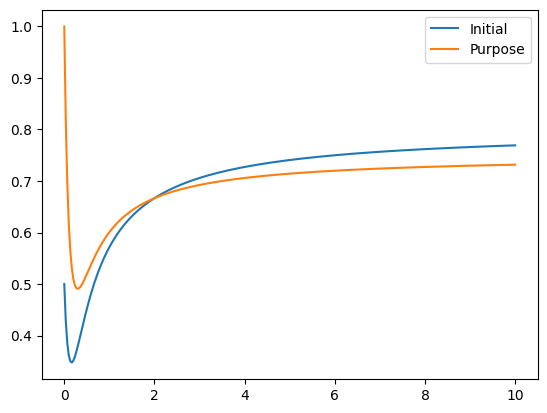

In [11]:
n = 4
def func(x, a1, a2, a3, a4):
    return (np.pi ** (-a1 * x) + a2 * x) / (a3 + a4 * x)

def minimizing_func(a):
    return np.sum((func(xs, *a) - ys) ** 2)

start_point = [6, 4, 2, 5]
result_point = [5, 3, 1, 4]
xs = np.linspace(0, 10, 300)
ys = func(xs, *result_point)

plt.plot(xs, func(xs, *start_point), label='Initial')
plt.plot(xs, ys, label='Purpose')
plt.legend()

Method: GD
	Result: [  9.41038681  74.25173091   1.0473039  106.84197487]
	Iterations: 10000
	Time: 8.89622712135315
	Mem: 401603 KiB

Method: Adam
	Result: [5.00000086 3.00000198 1.0000001  4.00000278]
	Iterations: 992
	Time: 1.0031616687774658
	Mem: 41151 KiB

Method: Gauss-Newton
	Result: [5.00000003 2.99999999 1.         3.99999998]
	Iterations: 26
	Time: 3.730043411254883
	Mem: 6492 KiB

Method: DogLeg
	Result: [5.60807232 3.37868204 0.99755879 4.53791972]
	Iterations: 1000
	Time: 124.87871766090393
	Mem: 42255 KiB

Expected: 5


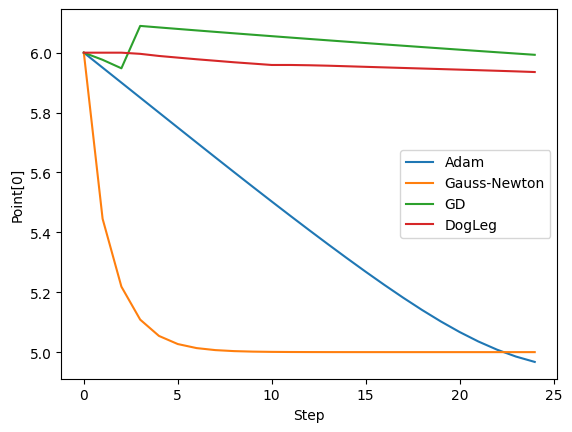

Expected: 3


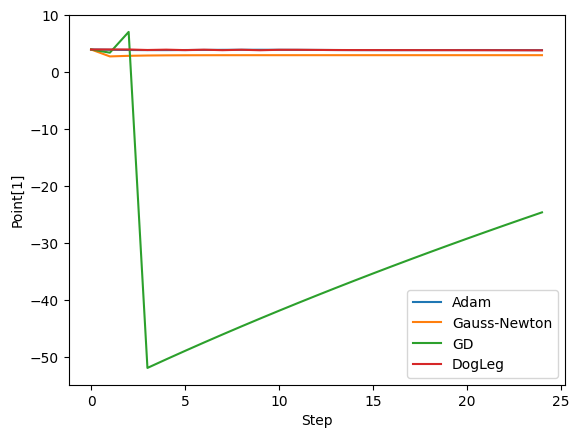

Expected: 1


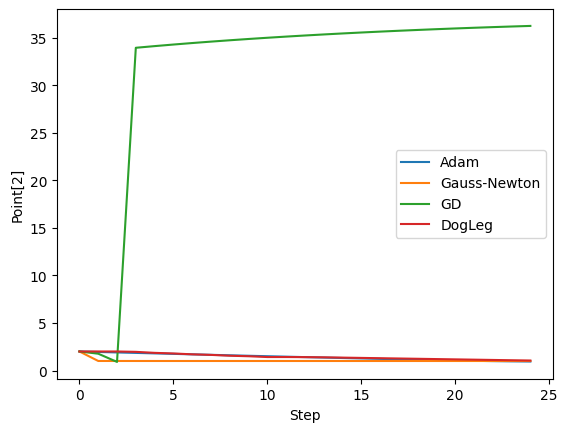

Expected: 4


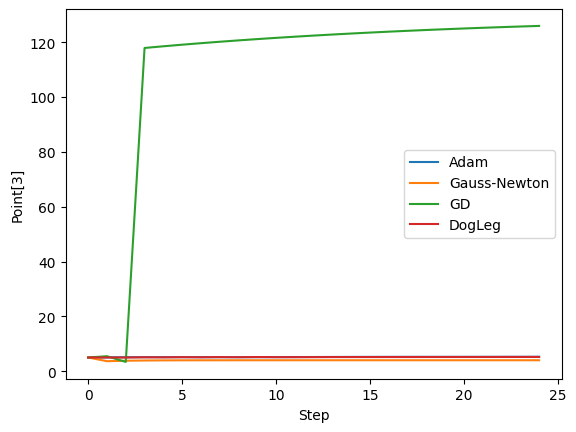

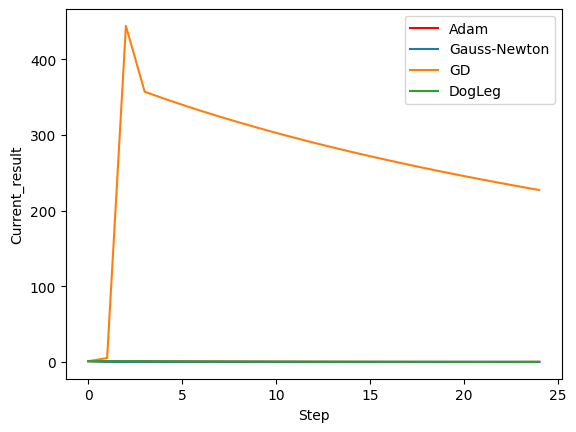

In [12]:
methods = ["GD", "Adam", "Gauss-Newton", "DogLeg"]


for i in range(4):
    start = time.time()
    tracemalloc.start()

    result_points = 0

    if i == 0:
        gd_points, gd_current_result = gd(minimizing_func, 0.3, start=start_point, epoch=10000)
        result_points = gd_points
    elif i == 1:
        adam_points, adam_current_result = sgd_adam(minimizing_func, start_point, 0.05, epoch=10000)
        result_points = adam_points
    elif i == 2:
        newton_points, newton_current_result = newton(nolinear_sum, start=start_point, epoch=1000)
        result_points = newton_points
    elif i == 3:
        dogleg_points, dogleg_current_result = dogleg(minimizing_func, start_point, delta=2, epoch=1000)
        result_points = dogleg_points

    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    total = sum(stat.size for stat in top_stats)
    tracemalloc.stop()
    end = time.time()

    print(f'Method: {methods[i]}\n\tResult: {result_points[-1]}\n\tIterations: {len(result_points)}')
    print(f'\tTime: {end - start}\n\tMem: {total} KiB\n')

size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points)) - 1
x = range(0, size)
for i in range(len(start_point)):
    print(f"Expected: {result_point[i]}")
    plt.plot(x, adam_points[:size, i], label='Adam')
    plt.plot(x, newton_points[:size, i], label='Gauss-Newton')
    plt.plot(x, gd_points[:size, i], label='GD')
    plt.plot(x, dogleg_points[:size, i], label='DogLeg')
    plt.xlabel("Step")
    plt.ylabel(f"Point[{i}]")
    plt.legend()
    plt.show()

plt.plot(x, adam_current_result[:size], 'r', label='Adam')
plt.plot(x, newton_current_result[:size], label='Gauss-Newton')
plt.plot(x, gd_current_result[:size], label='GD')
plt.plot(x, dogleg_current_result[:size], label='DogLeg')
plt.xlabel("Step")
plt.ylabel("Current_result")
plt.legend()

Method: GD
	Result: [ 6.32494199  8.01202898  1.21324002 11.54063331]
	Iterations: 10000
	Time: 9.378865957260132
	Mem: 402734 KiB

Method: Adam
	Result: [5.00000088 3.00000204 1.0000001  4.00000287]
	Iterations: 2653
	Time: 2.786754608154297
	Mem: 107284 KiB

Method: Gauss-Newton
	Result: [5.         2.99999999 1.         3.99999998]
	Iterations: 30
	Time: 5.048502445220947
	Mem: 7844 KiB

Method: DogLeg
	Result: [7.15084039 6.20428209 1.05787278 8.55212814]
	Iterations: 1000
	Time: 125.054434299469
	Mem: 42223 KiB

Expected: 5


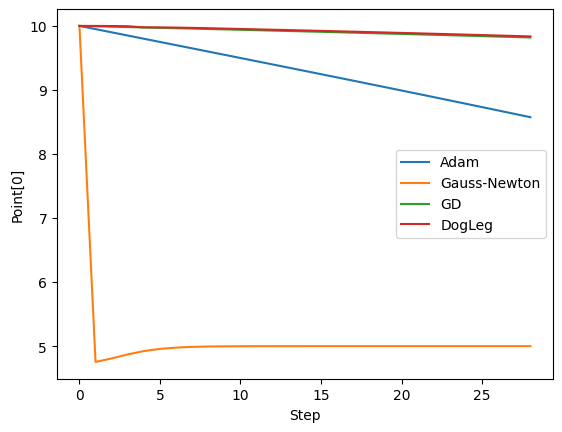

Expected: 3


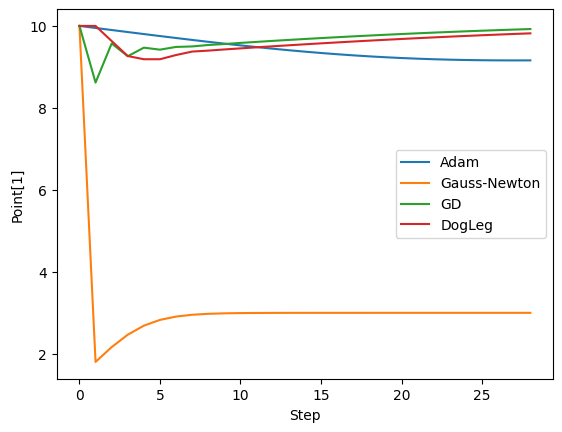

Expected: 1


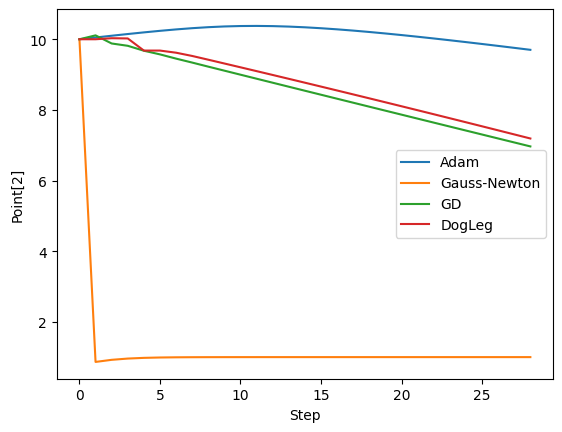

Expected: 4


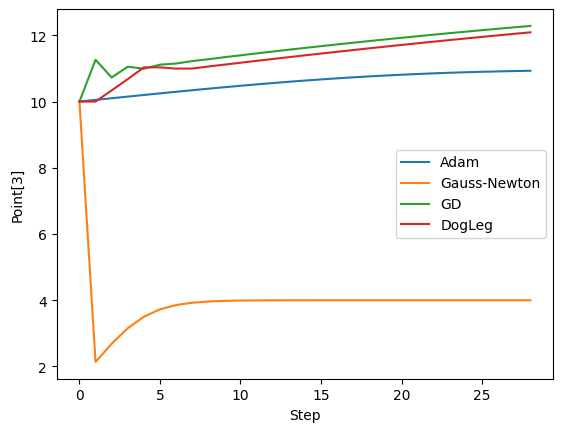

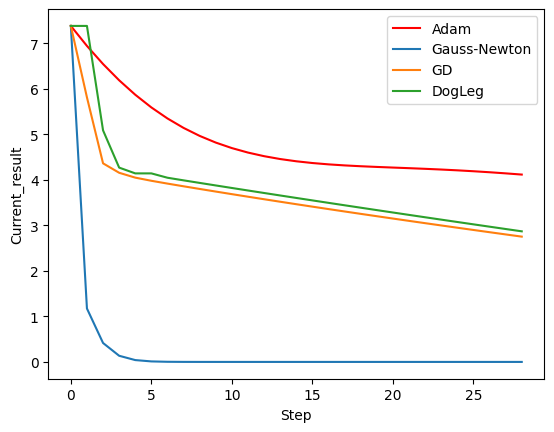

In [13]:
start_point = [10, 10, 10, 10]

for i in range(4):
    start = time.time()
    tracemalloc.start()

    result_points = 0

    if i == 0:
        gd_points, gd_current_result = gd(minimizing_func, 0.3, start=start_point, epoch=10000)
        result_points = gd_points
    elif i == 1:
        adam_points, adam_current_result = sgd_adam(minimizing_func, start_point, 0.05, epoch=10000)
        result_points = adam_points
    elif i == 2:
        newton_points, newton_current_result = newton(nolinear_sum, start=start_point, epoch=1000)
        result_points = newton_points
    elif i == 3:
        dogleg_points, dogleg_current_result = dogleg(minimizing_func, start_point, delta=2, epoch=1000)
        result_points = dogleg_points

    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    total = sum(stat.size for stat in top_stats)
    tracemalloc.stop()
    end = time.time()

    print(f'Method: {methods[i]}\n\tResult: {result_points[-1]}\n\tIterations: {len(result_points)}')
    print(f'\tTime: {end - start}\n\tMem: {total} KiB\n')

size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points)) - 1
x = range(0, size)
for i in range(len(start_point)):
    print(f"Expected: {result_point[i]}")
    plt.plot(x, adam_points[:size, i], label='Adam')
    plt.plot(x, newton_points[:size, i], label='Gauss-Newton')
    plt.plot(x, gd_points[:size, i], label='GD')
    plt.plot(x, dogleg_points[:size, i], label='DogLeg')
    plt.xlabel("Step")
    plt.ylabel(f"Point[{i}]")
    plt.legend()
    plt.show()

plt.plot(x, adam_current_result[:size], 'r', label='Adam')
plt.plot(x, newton_current_result[:size], label='Gauss-Newton')
plt.plot(x, gd_current_result[:size], label='GD')
plt.plot(x, dogleg_current_result[:size], label='DogLeg')
plt.xlabel("Step")
plt.ylabel("Current_result")
plt.legend()

#### $f(x) = \frac{2}{3 \cdot x + 4 + x^2}$

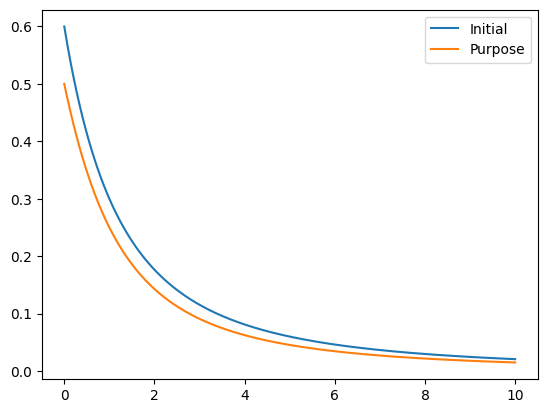

In [14]:
n = 3
func = lambda x, a1, a2, a3: a1 / (a2 * x + a3 + x ** 2)

start_point = [3, 4, 5]
result_point = [2, 3, 4]
xs = np.linspace(0, 10, 300)
ys = func(xs, *result_point)

plt.plot(xs, func(xs, *start_point), label='Initial')
plt.plot(xs, ys, label='Purpose')
plt.legend()

Method: GD
	Result: [2.00022852 3.00059068 4.00040569]
	Iterations: 10000
	Time: 4.697217226028442
	Mem: 321352 KiB

Method: Adam
	Result: [2.00000887 3.00002253 4.0000159 ]
	Iterations: 1470
	Time: 0.8171632289886475
	Mem: 48204 KiB

Method: Gauss-Newton
	Result: [2.00000005 3.00000006 4.00000006]
	Iterations: 25
	Time: 2.1855180263519287
	Mem: 6484 KiB

Method: DogLeg
	Result: [2.1317687  3.34200057 4.23372338]
	Iterations: 1000
	Time: 80.46490287780762
	Mem: 34359 KiB

Expected: 2


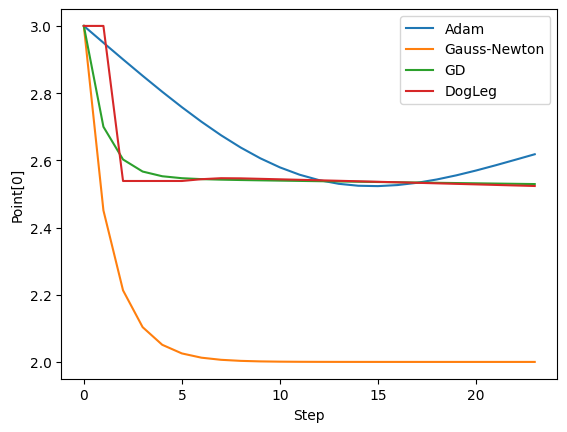

Expected: 3


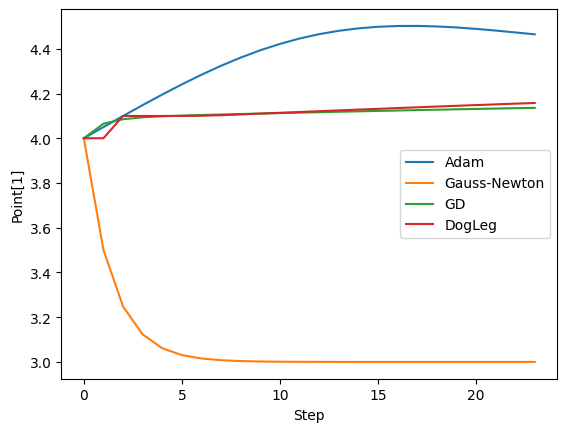

Expected: 4


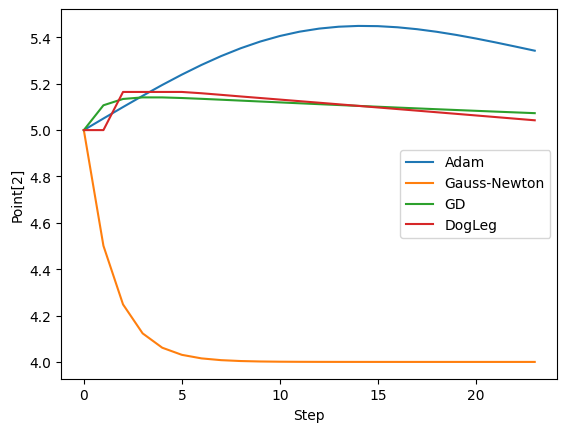

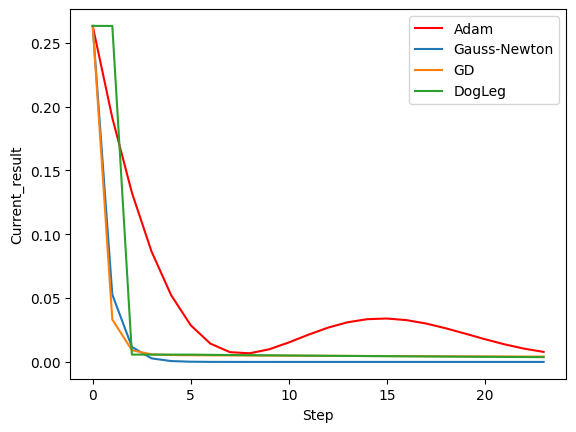

In [15]:
methods = ["GD", "Adam", "Gauss-Newton", "DogLeg"]


for i in range(4):
    start = time.time()
    tracemalloc.start()

    result_points = 0

    if i == 0:
        gd_points, gd_current_result = gd(minimizing_func, 0.3, start=start_point, epoch=10000)
        result_points = gd_points
    elif i == 1:
        adam_points, adam_current_result = sgd_adam(minimizing_func, start_point, 0.05, epoch=10000)
        result_points = adam_points
    elif i == 2:
        newton_points, newton_current_result = newton(nolinear_sum, start=start_point, epoch=1000)
        result_points = newton_points
    elif i == 3:
        dogleg_points, dogleg_current_result = dogleg(minimizing_func, start_point, delta=2, epoch=1000)
        result_points = dogleg_points

    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    total = sum(stat.size for stat in top_stats)
    tracemalloc.stop()
    end = time.time()

    print(f'Method: {methods[i]}\n\tResult: {result_points[-1]}\n\tIterations: {len(result_points)}')
    print(f'\tTime: {end - start}\n\tMem: {total} KiB\n')

size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points)) - 1
x = range(0, size)
for i in range(len(start_point)):
    print(f"Expected: {result_point[i]}")
    plt.plot(x, adam_points[:size, i], label='Adam')
    plt.plot(x, newton_points[:size, i], label='Gauss-Newton')
    plt.plot(x, gd_points[:size, i], label='GD')
    plt.plot(x, dogleg_points[:size, i], label='DogLeg')
    plt.xlabel("Step")
    plt.ylabel(f"Point[{i}]")
    plt.legend()
    plt.show()

plt.plot(x, adam_current_result[:size], 'r', label='Adam')
plt.plot(x, newton_current_result[:size], label='Gauss-Newton')
plt.plot(x, gd_current_result[:size], label='GD')
plt.plot(x, dogleg_current_result[:size], label='DogLeg')
plt.xlabel("Step")
plt.ylabel("Current_result")
plt.legend()

Method: GD
	Result: [2.71571181 4.88506239 5.26548817]
	Iterations: 10000
	Time: 5.114243745803833
	Mem: 320947 KiB

Method: Adam
	Result: [2.00000984 3.00002509 4.0000176 ]
	Iterations: 5164
	Time: 2.9271793365478516
	Mem: 167052 KiB

Method: Gauss-Newton
	Result: [2.00000012 3.0000002  4.00000018]
	Iterations: 25
	Time: 2.2772586345672607
	Mem: 5956 KiB

Method: DogLeg
	Result: [3.27014985 6.37245695 6.23568282]
	Iterations: 1000
	Time: 80.89885354042053
	Mem: 34476 KiB

Expected: 2


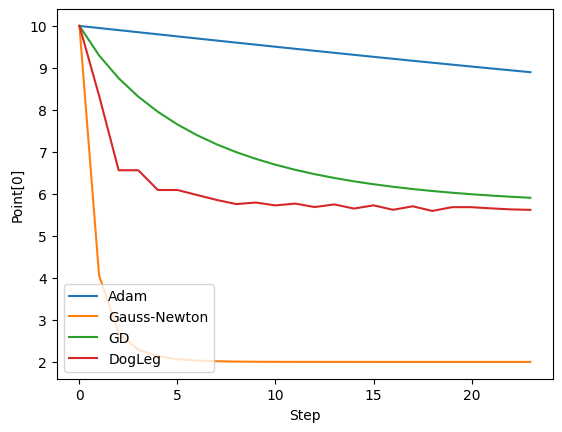

Expected: 3


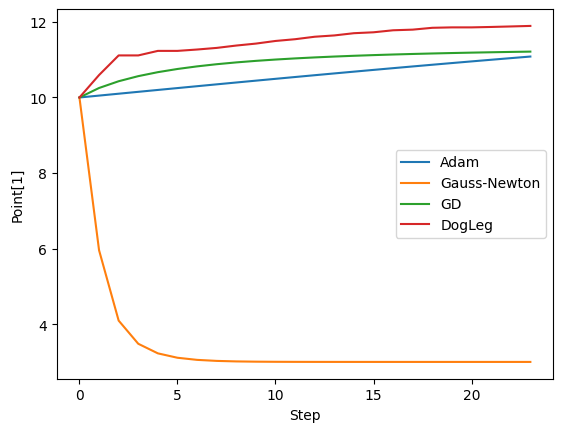

Expected: 4


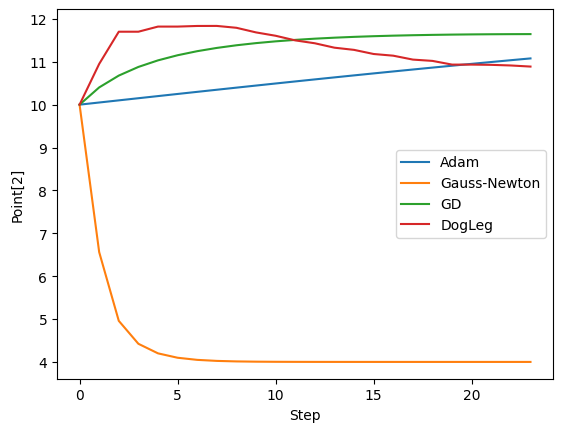

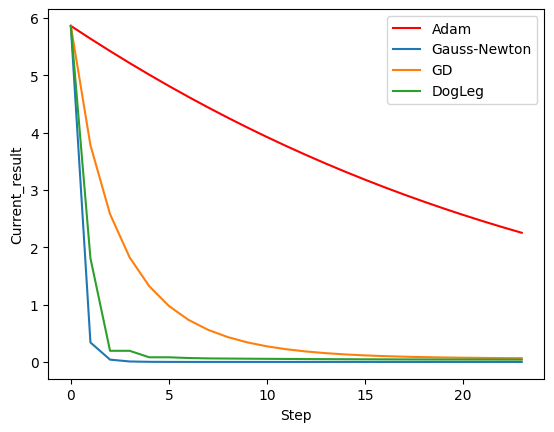

In [16]:
start_point = [10, 10, 10]

methods = ["GD", "Adam", "Gauss-Newton", "DogLeg"]

for i in range(4):

    start = time.time()
    tracemalloc.start()

    result_points = 0

    if i == 0:
        gd_points, gd_current_result = gd(minimizing_func, 0.3, start=start_point, epoch=10000)
        result_points = gd_points
    elif i == 1:
        adam_points, adam_current_result = sgd_adam(minimizing_func, start_point, 0.05, epoch=10000)
        result_points = adam_points
    elif i == 2:
        newton_points, newton_current_result = newton(nolinear_sum, start=start_point, epoch=1000)
        result_points = newton_points
    elif i == 3:
        dogleg_points, dogleg_current_result = dogleg(minimizing_func, start_point, delta=2, epoch=1000)
        result_points = dogleg_points

    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    total = sum(stat.size for stat in top_stats)
    tracemalloc.stop()
    end = time.time()

    print(f'Method: {methods[i]}\n\tResult: {result_points[-1]}\n\tIterations: {len(result_points)}')
    print(f'\tTime: {end - start}\n\tMem: {total} KiB\n')

size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points)) - 1
x = range(0, size)
for i in range(len(start_point)):
    print(f"Expected: {result_point[i]}")
    plt.plot(x, adam_points[:size, i], label='Adam')
    plt.plot(x, newton_points[:size, i], label='Gauss-Newton')
    plt.plot(x, gd_points[:size, i], label='GD')
    plt.plot(x, dogleg_points[:size, i], label='DogLeg')
    plt.xlabel("Step")
    plt.ylabel(f"Point[{i}]")
    plt.legend()
    plt.show()

plt.plot(x, adam_current_result[:size], 'r', label='Adam')
plt.plot(x, newton_current_result[:size], label='Gauss-Newton')
plt.plot(x, gd_current_result[:size], label='GD')
plt.plot(x, dogleg_current_result[:size], label='DogLeg')
plt.xlabel("Step")
plt.ylabel("Current_result")
plt.legend()

# Вывод
Как не удивительно, лучше всего на представленных функциях себя показал метод Gauss-Newton, это выражается и в количестве проходов алгоритма и во времени исполнения и в количестве затраченной памяти, чуть хуже себя показал Adam, результат у него был довольно точный, но ресурсов тратилось больше. Градиентный спуск провалился на первой функции и показал более-менее адекватный результат на второй, DogLeg же, наоборот, показывал близкий результат на первой функции и плохой на второй.